# CIFAR10 with Inception module - TF2.X

In [1]:
import tensorflow as tf
print(tf.__version__)
!python --version

2.5.0
Python 3.7.11


In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing and hyperparameters setup

In [3]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 25
lrate = 0.01
decay = lrate/epochs
data_augmentation = True
num_classes = 10

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Create the inception module

In [6]:
input_img = Input(shape=(32,32,3))

In [7]:
group_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
group_1 = Conv2D(64, (3,3), padding='same', activation='relu')(group_1)
group_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
group_2 = Conv2D(64, (5,5), padding='same', activation='relu')(group_2)
group_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
group_3 = Conv2D(64, (1,1), padding='same', activation='relu')(group_3)

In [10]:
output = concatenate([group_1, group_2, group_3], axis=3)

In [11]:
output = Flatten()(output)
out = Dense(10, activation='softmax')(output)

In [12]:
model = Model(inputs = input_img, outputs= out)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 3)    0           input_1[0][0]                    
______________________________________________________________________________________________

## Setting up the training

In [14]:
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [34]:
filepath = "/content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/inception-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [35]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5, restore_best_weights=True)
callbacks = [checkpoint, early]

In [36]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=30,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.2,
        # set range for random zoom
        zoom_range=0.2,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

Using real-time data augmentation.


## Train model

In [37]:
datagen.fit(X_train)
X_train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [38]:
print(f"Number of samples:{X_train_generator.n}")
print(f"Batch size:{X_train_generator.batch_size}")
step_size_train = X_train_generator.n // X_train_generator.batch_size
print(f"Step size train: {step_size_train}")

Number of samples:50000
Batch size:32
Step size train: 1562


In [39]:
history = model.fit(X_train_generator,
                        validation_data=(X_test, y_test),
                        epochs=epochs, verbose=1,
                        steps_per_epoch=step_size_train,
                        callbacks=callbacks)

Epoch 1/25
1562/1562 [==============================] - 40s 26ms/step - loss: 1.1766 - accuracy: 0.5901 - val_loss: 1.0477 - val_accuracy: 0.6343

Epoch 00001: val_loss improved from inf to 1.04766, saving model to /content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/inception-model.h5
Epoch 2/25
1562/1562 [==============================] - 35s 23ms/step - loss: 1.1706 - accuracy: 0.5926 - val_loss: 1.0325 - val_accuracy: 0.6399

Epoch 00002: val_loss improved from 1.04766 to 1.03252, saving model to /content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/inception-model.h5
Epoch 3/25
1562/1562 [==============================] - 39s 25ms/step - loss: 1.1577 - accuracy: 0.5960 - val_loss: 1.0273 - val_accuracy: 0.6464

Epoch 00003: val_loss improved from 1.03252 to 1.02735, saving model to /content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/inception-model.h5
Epoch 4/25
1562/1562 [==============================] - 35s 23ms/step - loss: 1.1547 - accuracy: 0.5964 - val_loss: 1.0107 - val_accuracy: 0.6490


## Visualizing metrics

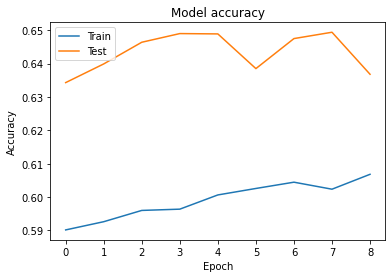

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

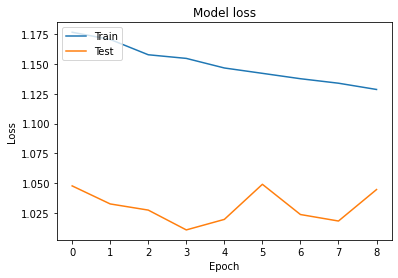

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

## Reference:
- https://keras.io/api/applications/